In [2]:
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Defino funciones

In [3]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [4]:
from sklearn.metrics import mean_absolute_error

def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    error = mean_absolute_error(test_labels, predict)
    score = model.score(test_features,test_labels)
    
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(score*100))
    print('Mean abs error: {:0.4f}.'.format(error))

    
    return predict

In [5]:
def transformar(df,colums,func):
    for x in colums:
        df[x]=df[x].transform(lambda y: func(y))
        
columnas_para_transformar = ["metroscubiertos","metrostotales","metroscubiertostotales"]

#transformar(df1,columnas_para_transformar,np.sqrt)

## Importo dataset

In [6]:
df = pd.read_csv('../data/features.csv')
df_test = pd.read_csv('../data/test_features.csv')

df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

In [7]:
df = df.drop(columns=["direccion","descripcion","titulo"])
df_test = df_test.drop(columns=["direccion","descripcion","titulo"])

df_ids = df_test["id"]
df = df.drop(columns=["id"])
df_test = df_test.drop(columns=["id"])



## Divido data set


In [18]:
x = df[df.columns.drop("precio")]
y = df['precio']

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

x_train, x_test, y_train = x, df_test, y

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 40) y=(240000,)
Train shapes: X=(240000, 40) y=(240000,)
Test  shapes: X=(60000, 40)  y=(48000,)


 ## Completo los datos faltantes

In [19]:
oneHot = ['tipodepropiedad','provincia']
binary = ['ciudad']

In [20]:
#Completo los numericos
x_train = imputar(x_train)
x_test  = imputar(x_test )

#Completo los categoricos
imp = SimpleImputer(strategy="constant",fill_value="-")

x_train["tipodepropiedad"] = imp.fit_transform(x_train[["tipodepropiedad"]])
x_train["provincia"] = imp.fit_transform(x_train[["provincia"]])
x_train["ciudad"] = imp.fit_transform(x_train[["ciudad"]])

x_test["tipodepropiedad"] = imp.fit_transform(x_test[["tipodepropiedad"]])
x_test["provincia"] = imp.fit_transform(x_test[["provincia"]])
x_test["ciudad"] = imp.fit_transform(x_test[["ciudad"]])

In [21]:
x_train["metroscubiertostotales"]=x_train["metroscubiertos"]+x_train["metrostotales"]
x_train["ambientes"]=x_train["banos"]+x_train["habitaciones"]
x_train["ambientesygarage"]=x_train["banos"]+x_train["habitaciones"]+x_train["garages"]

x_test["metroscubiertostotales"]=x_test["metroscubiertos"]+x_test["metrostotales"]
x_test["ambientes"]=x_test["banos"]+x_test["habitaciones"]
x_test["ambientesygarage"]=x_test["banos"]+x_test["habitaciones"]+x_test["garages"]

 ## Genero los encodes

In [22]:
data_cols = x_train._get_numeric_data().columns
baseline_data = x_train[data_cols]

encoder = ce.OneHotEncoder()

encoded = encoder.fit_transform(x_train[oneHot])
data = baseline_data.join(encoded)

encoder = ce.BinaryEncoder()
encoded = encoder.fit_transform(x_train[binary])
data_train = data.join(encoded)

data_train.shape

(240000, 107)

In [23]:
data_cols = x_test._get_numeric_data().columns
baseline_data = x_test[data_cols]

encoder = ce.OneHotEncoder()

encoded = encoder.fit_transform(x_test[oneHot])
data = baseline_data.join(encoded)

encoder = ce.BinaryEncoder()
encoded = encoder.fit_transform(x_test[binary])
data_test = data.join(encoded)

data_test.shape

(60000, 105)


## Modelo y entreno

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 1,
                                  n_estimators = 250,
                                  max_depth = 15, 
                                )

In [25]:
model.fit(data_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

## Predicciones

In [28]:
for a in data_train.columns[~data_train.columns.isin(data_test.columns)]:
    data_test[a] = 0

data_test.shape[1] == x_train.shape[1]

print(f"Train shapes: X={data_train.shape} y={data_train.shape}")
print(f"Test  shapes: X={data_test.shape}  y={data_test.shape}")

Train shapes: X=(240000, 107) y=(240000, 107)
Test  shapes: X=(60000, 107)  y=(60000, 107)


In [17]:
predecir(model,data_train,y_train,data_test,y_test)

Entrenamiento: 87.3666%
Testeo: 56.5830%.
Mean abs error: 862324.0316.


array([1364505.04511006, 3870718.98356382, 1021616.89367257, ...,
       2319440.89299057, 1047321.51954704, 3231483.94790176])

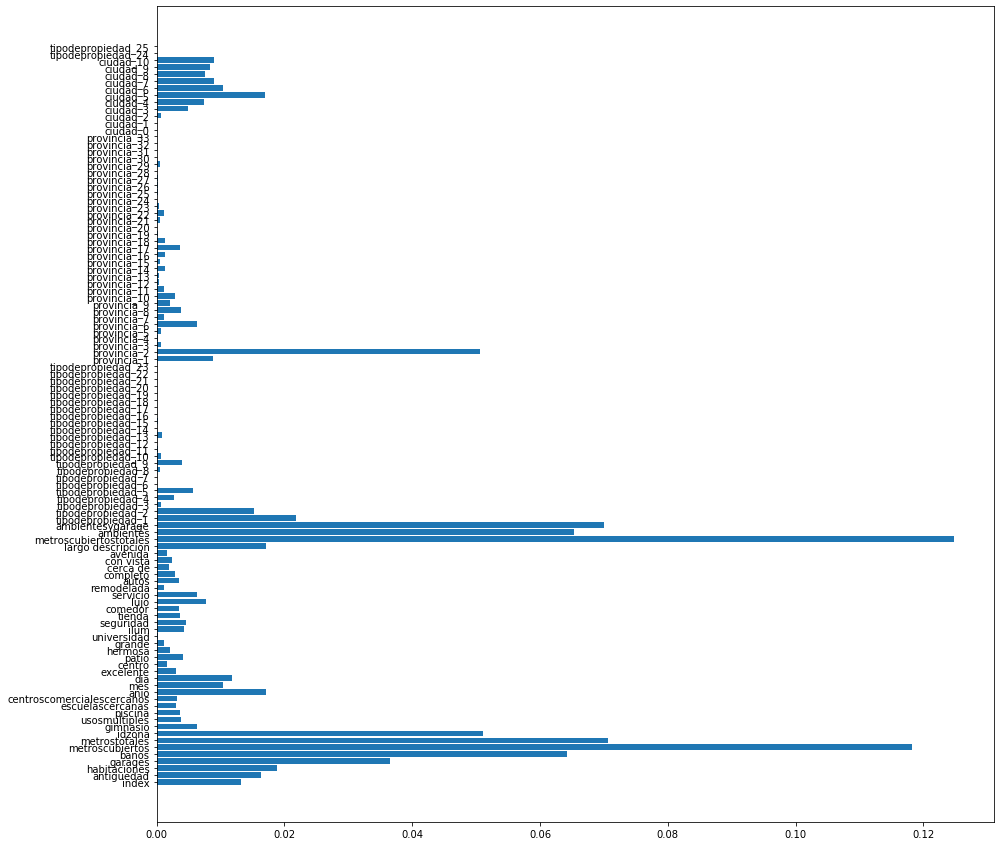

In [111]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_
ax = plt.barh(x_train.columns, importancia)

In [29]:
#Predigo los precios
predict = model.predict(data_test)

In [30]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")

In [31]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")
result.to_csv("../data/results/resultRF_Features.csv", index=False)